In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Read in data:

In [2]:
df = pd.read_csv("../emerson/metadata_merged_full.tsv", sep="\t", index_col=[0])
hla_cols = [c for c in df.columns if c.startswith("HLA")]


Drop columns with nan values, this drops almost half of the samples

In [3]:
hla_df = df.set_index("sample_name")[hla_cols].copy().dropna()

In [4]:
len(hla_df)

393

In [5]:
hla_df

,HLA-A*33:01,HLA-A*33:03,HLA-A*26:01,HLA-A*31:01,HLA-A*11:01,HLA-A*23:01,HLA-A*03:01,HLA-A*24:03,HLA-A*34:01,HLA-A*03:02,...,HLA-DQAB*01:03_03:01,HLA-DQAB*01:02_03:02,HLA-DQAB*02:01_06:09,HLA-DQAB*02:01_06:02,HLA-DQAB*02:01_06:03,HLA-DQAB*01:03_06:01,HLA-DQAB*01:03_06:02,HLA-DPAB*01:03_10:01,HLA-DQAB*01:02_04:02,HLA-DPAB*02:02_05:01
sample_name,,,,,,,,,,,,,,,,,,,,,
P00030,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P00061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P00127,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P00175,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P00078,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P00349,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P00305,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
P00389,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Visualize the HLA matrix: columns represent the presence or absence of a HLA allele in a particular sample (row)

<Axes: ylabel='sample_name'>

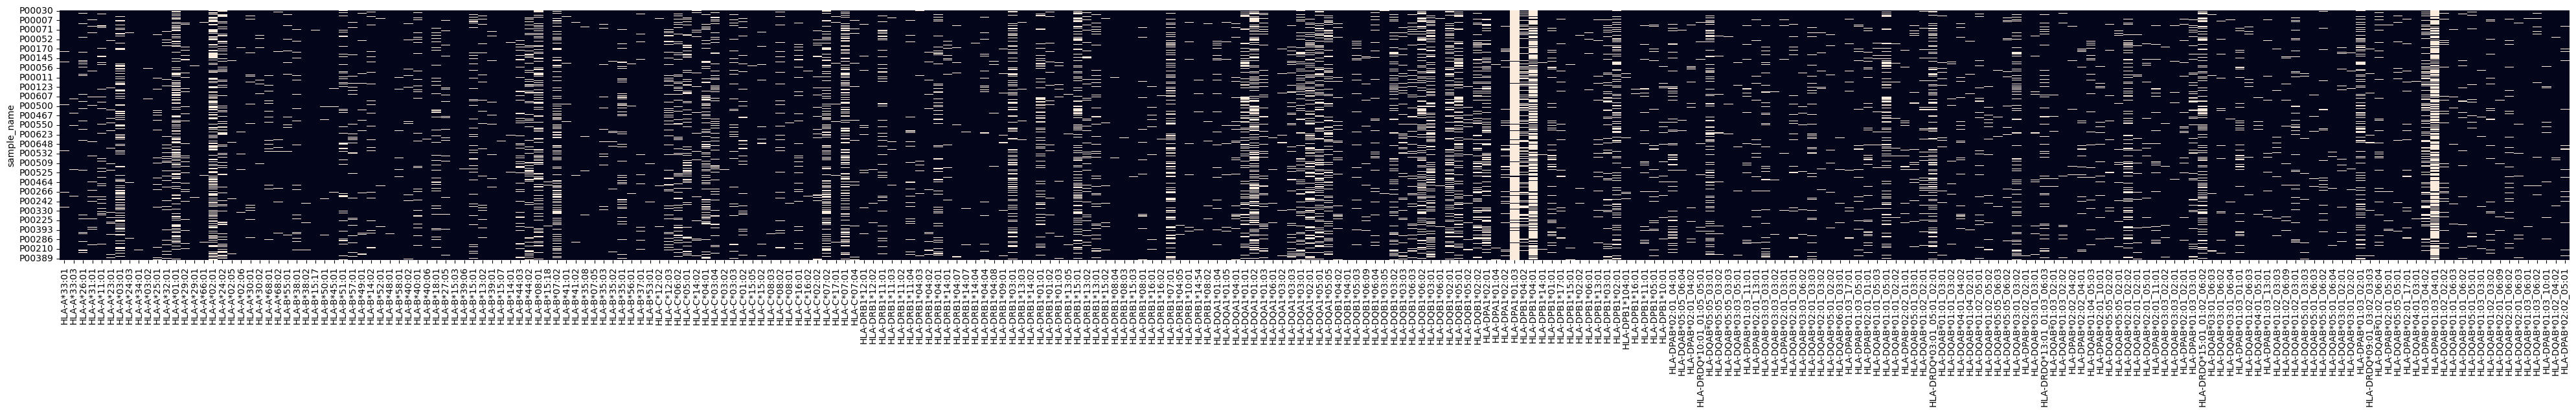

In [6]:
fig, ax = plt.subplots(figsize=(50,5))
sns.heatmap(hla_df.dropna().astype(int), cbar=False)

## Dimensionality reduction

Two different methods were used:

- Simple K-means on the one-hot encoded HLA typing arrays, with K in this case set to 10 (could be increased/reduced, although the results might be less meaningful)
- UMAP dimensionality reduction using the hamming distance + DBScan density-based clustering. (The number of clusters cannot be preset, however this method allows for outliers)

For the UMAP method you can cite this paper:
- https://doi.org/10.48550/arXiv.1802.03426
- https://joss.theoj.org/papers/10.21105/joss.00205


In [7]:
import umap
import hdbscan
from sklearn.cluster import KMeans

/home/vincent/miniforge-pypy3/envs/raptcr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-22 17:44:09.088630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 17:44:09.182719: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-22 17:44:09.643752: W tensorflow/compiler/xla/stream_executor/platform/d

In [8]:
embedding = umap.UMAP(
    metric="hamming",
    n_neighbors=30,
    min_dist=0.0,
    ).fit_transform(hla_df.dropna())

hla_df["UMAP_x"], hla_df["UMAP_y"] = embedding.T

umap_hdb_cluster_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=2,
).fit_predict(embedding)

hla_df["umap_hdb_cluster_labels"] = umap_hdb_cluster_labels
hla_df["umap_hdb_cluster_labels"] = hla_df["umap_hdb_cluster_labels"].astype(str)

/home/vincent/miniforge-pypy3/envs/raptcr/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


In [9]:
kmeans_cluster_labels = KMeans(n_clusters=10).fit_predict(hla_df[hla_cols])

hla_df["kmeans_cluster_labels"] = kmeans_cluster_labels
hla_df["kmeans_cluster_labels"] = hla_df["kmeans_cluster_labels"].astype(str)

/home/vincent/miniforge-pypy3/envs/raptcr/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='UMAP_x', ylabel='UMAP_y'>

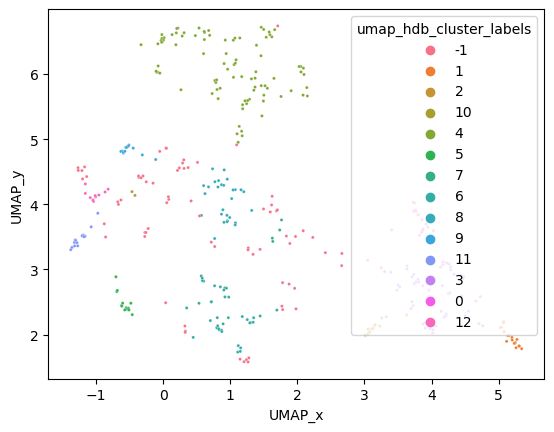

In [10]:
sns.scatterplot(hla_df, x='UMAP_x', y='UMAP_y', s=5, hue="umap_hdb_cluster_labels")

In [13]:
px.scatter(data_frame=hla_df.reset_index(), x="UMAP_x", y="UMAP_y", hover_name="sample_name", color="umap_hdb_cluster_labels", title="UMAP dimensionality reduction + DBscan clustering")

In [15]:
px.scatter(data_frame=hla_df.reset_index(), x="UMAP_x", y="UMAP_y", hover_name="sample_name", color="kmeans_cluster_labels", title="Direct k-means clustering")

## Save the results

In [16]:
hla_df[["UMAP_x","UMAP_y","umap_hdb_cluster_labels","kmeans_cluster_labels"]].to_csv("hla_clusters.tsv", sep="\t")

In [19]:
pd.merge(df, hla_df[["UMAP_x","UMAP_y","umap_hdb_cluster_labels","kmeans_cluster_labels"]].reset_index(), on="sample_name", how="left")

,sample_name,species,locus,product_subtype,hla_class_i,hla_class_ii,sample_amount_ng,sample_cells_mass_estimate,counting_method,primer_set,...,HLA-DQAB*02:01_06:03,HLA-DQAB*01:03_06:01,HLA-DQAB*01:03_06:02,HLA-DPAB*01:03_10:01,HLA-DQAB*01:02_04:02,HLA-DPAB*02:02_05:01,UMAP_x,UMAP_y,umap_hdb_cluster_labels,kmeans_cluster_labels
0,P00030,Human,TCRB,Deep,NaN,NaN,1165.71997,179341.0,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,1.445110,3.308099,-1,6
1,P00061,Human,TCRB,Deep,NaN,NaN,1096.12000,168633.0,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,5.117915,1.896591,1,1
2,P00127,Human,TCRB,Deep,NaN,NaN,3636.47998,559458.0,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,3.013370,1.992949,2,9
3,P00033,Human,TCRB,Deep,NaN,NaN,3636.47998,559458.0,v2,Human-TCRB-PD1x,...,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN
4,P00175,Human,TCRB,Deep,NaN,NaN,3636.47998,559458.0,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,-0.463435,4.195048,10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,P00379,Human,TCRB,Deep,NaN,NaN,1802.76001,277347.0,v2,Human-TCRB-PD1x,...,NaN,NaN,NaN,False,NaN,False,NaN,NaN,NaN,NaN
662,P00305,Human,TCRB,Deep,NaN,NaN,NaN,NaN,v2,Human-TCRB-PD1x,...,True,False,False,False,False,False,2.027370,6.115000,4,4
663,P00389,Human,TCRB,Deep,NaN,NaN,3636.47998,559458.0,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,-0.507814,2.380828,5,0
664,P00231,Human,TCRB,Deep,NaN,NaN,NaN,NaN,v2,Human-TCRB-PD1x,...,False,False,False,False,False,False,3.821436,3.522074,0,9
